<a href="https://colab.research.google.com/github/henriquemin/portfolio_data_science/blob/master/Bakery_Market_Basket_Analysis_Apriori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bakery Market Basket Analysis**
---


* In food market finding a new way to increase sales and customer engagement 
are the most common and difficult task to deal. Increase the number of competitors, economy, seazonal issues and a lot of others features that 
influence in this market.

* To have advatange it is very important to understand the customer behavior, store layout and do customized offers to this customer.

* Thinking about that Machine Learning can help to understand the customer behavior and analyze the sales history to make predictions to boost the sales. And one option to do that is using Market Basket Analysis, that is a method to understand the combination of items that estimulate more sales.

* In this project I am going to use Apriori algorithm to develop a Market Basket Analysis to create a recommendation basket to develop new strategies for customers.

## **Exploratory Data Analysis (EDA)**
---

Doing EDA will help to understand the dataset and which features to select to find the label of prediction


### Import Libraries







In [0]:
#pip install pandas mlxtend
#!pip install pandas-profiling
#!pip install --upgrade pandas_profiling

In [0]:
# Importation of libraries
import pandas as pd
import numpy as np
import io
from google.colab import files
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

print(f'Libraries loaded!')

Libraries loaded!


### Load file & Data preparation







In [0]:
# !pip install kaggle

In [0]:
# Opening the file into Google Colab 
upload_file = files.upload()
print(f'File(s) uploaded!')

In [0]:
# Configuration steps for .json file:
# Check if the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 65 Apr 20 13:42 kaggle.json


In [0]:
# Download the requested dataset by kaggle API
!kaggle datasets download -d sulmansarwar/transactions-from-a-bakery

#Unzip the dataset file
!unzip \*.zip

transactions-from-a-bakery.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  transactions-from-a-bakery.zip
replace BreadBasket_DMS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
# Open and Creating the dataset
df_initial = pd.read_csv('BreadBasket_DMS.csv', header = 0)
df_initial.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam



### Identifying Features & Labels

In [0]:
# Dataset info
display(df_initial.info())
print('\n')

# Descriptive statistics of the data
display(df_initial.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


None

,Transaction
count,21293.000000
mean,4951.990889
std,2787.758400
min,1.000000
25%,2548.000000
50%,5067.000000
75%,7329.000000
max,9684.000000


### Missing Value Identification

In [0]:
# Identify null values on dataset
print('  ' * 10 + " Display information about column types and number of null values " + '  ' * 10 )
print('--' * 50)

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))

if(any(df_initial.isnull().any())):
    print()
    display(tab_info)
else:
    print('NO missing data')

                     Display information about column types and number of null values                     
----------------------------------------------------------------------------------------------------
NO missing data


Check for hidden missing values


In [0]:
#Let's check the 'hidden' missing values in the dataset
missing_value = ["NaN", "NONE", "None", "Nil", "nan", "none", "nil", 0]

print('---------------------------------------------------------')
print("There are {0} 'hidden' missing values in the 'Item'column.".format(len(df_initial[df_initial.Item.isin(missing_value)])))
print("There are {0} 'hidden' missing values in the 'Transaction'.".format(len(df_initial[df_initial.Transaction.isin(missing_value)])))
print('---------------------------------------------------------')
df_initial[df_initial.Item.isin(missing_value)].head()

---------------------------------------------------------
There are 786 'hidden' missing values in the 'Item'column.
There are 0 'hidden' missing values in the 'Transaction'.
---------------------------------------------------------


,Date,Time,Transaction,Item
26,2016-10-30,10:27:21,11,NONE
38,2016-10-30,10:34:36,15,NONE
39,2016-10-30,10:34:36,15,NONE
66,2016-10-30,11:05:30,29,NONE
80,2016-10-30,11:37:10,37,NONE


Drop the missing values


In [0]:
# Selecting the row values to drop in the selected column
bread = df_initial.drop(df_initial[df_initial.Item == "NONE"].index)
print("Number of rows: {0:,} (original 21,293) ".format(len(bread)))
print('----------------------------------------')
bread.head()

# After removing the missing values, the number of rows left is 20,507 (original 21,293 minus 786 missing)

Number of rows: 20,507 (original 21,293) 
----------------------------------------


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


### Dataset Transformation


Convert to DatetimeIndex


In [0]:
# Creating a column of DateTimeIndex
bread['Datetime'] = pd.to_datetime(bread['Date'] + ' ' + bread['Time'])
bread = bread[["Datetime", "Transaction", "Item"]].set_index("Datetime")
bread.head()

,Transaction,Item
Datetime,,
2016-10-30 09:58:11,1,Bread
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:07:57,3,Hot chocolate
2016-10-30 10:07:57,3,Jam


Extract hour and days of week


In [0]:
# Extract hour of the day and weekday of the week
# For Datetimeindex: the day of the week are Monday=0, Sunday=6, thereby +1 to become Monday=1, Sunday=7
bread["Hour"] = bread.index.hour
bread["Weekday"] = bread.index.weekday + 1

bread.head()

,Transaction,Item,Hour,Weekday
Datetime,,,,
2016-10-30 09:58:11,1,Bread,9,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:07:57,3,Hot chocolate,10,7
2016-10-30 10:07:57,3,Jam,10,7


### Exploring data attributes

In [0]:
total_items = len(bread)
total_days = len(np.unique(bread.index.date))
total_months = len(np.unique(bread.index.month))
average_items = int(total_items / total_days)
unique_items = bread.Item.unique().size

print("Total unique_items: {} sold by the Bakery".format(unique_items))
print('-----------------------------')
print("Total sales: {} items sold in {} days throughout {} months".format(total_items, total_days, total_months))
print('-----------------------------')
print("Average_items daily sales: {}".format(average_items))

Total unique_items: 94 sold by the Bakery
-----------------------------
Total sales: 20507 items sold in 159 days throughout 7 months
-----------------------------
Average_items daily sales: 128


Top 10 items

In [0]:
# Rank the top 10 best-selling items
counts = bread.Item.value_counts()
percent = bread.Item.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
top_10 = pd.DataFrame({'counts': counts, '%': percent})[:10]

print('-----------------------------')
print('Top 10 items')
print('-----------------------------')
display(top_10)

-----------------------------
Top 10 items
-----------------------------


,counts,%
Coffee,5471,26.7%
Bread,3325,16.2%
Tea,1435,7.0%
Cake,1025,5.0%
Pastry,856,4.2%
Sandwich,771,3.8%
Medialuna,616,3.0%
Hot chocolate,590,2.9%
Cookies,540,2.6%
Brownie,379,1.8%


Bar Charts

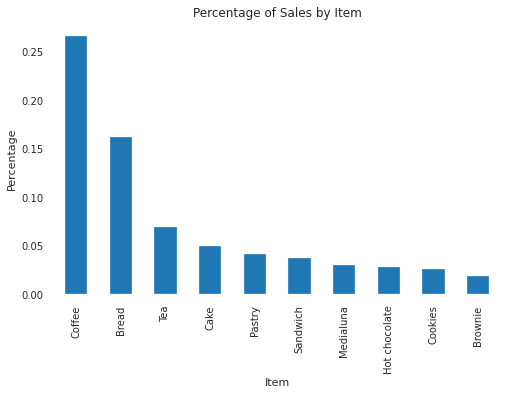

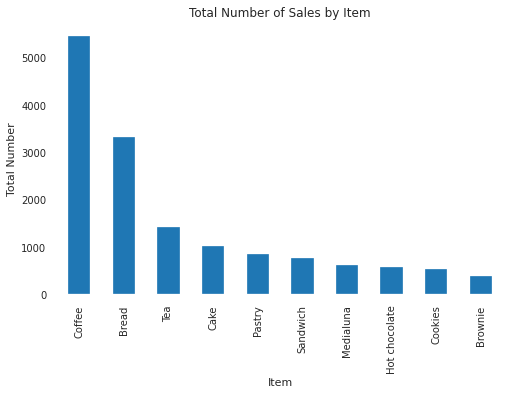

In [0]:
# Rank by percentage
plt.figure(figsize=(8,5))
bread.Item.value_counts(normalize=True)[:10].plot(kind="bar", title="Percentage of Sales by Item").set(xlabel="Item", ylabel="Percentage")
plt.show()

print('\n')
# Rank by value
plt.figure(figsize=(8,5))
bread.Item.value_counts()[:10].plot(kind="bar", title="Total Number of Sales by Item").set(xlabel="Item", ylabel="Total Number")
plt.show()

Time Series

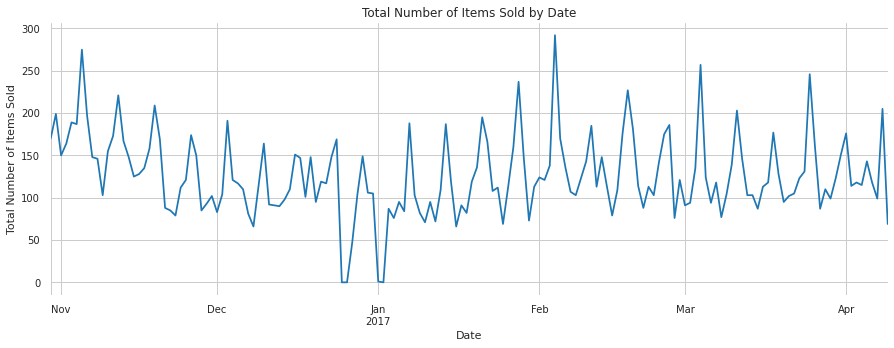

In [0]:
# Number of items sold by day
bread["Item"].resample("D").count().plot(figsize=(15,5), grid=True, title="Total Number of Items Sold by Date").set(xlabel="Date", ylabel="Total Number of Items Sold")
plt.show()

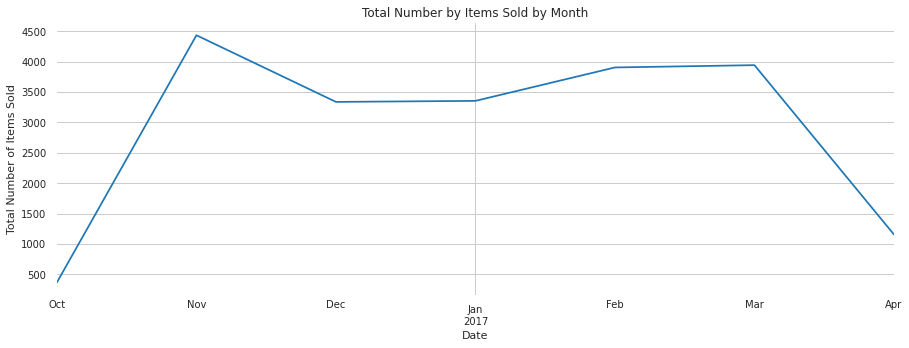

In [0]:
# Number of items sold by month
bread["Item"].resample("M").count().plot(figsize=(15,5), grid=True, title="Total Number by Items Sold by Month").set(xlabel="Date", ylabel="Total Number of Items Sold")
plt.show()

           Item
Hour           
1      0.006289
7      0.150943
8      4.056604
9     12.364780
10    16.767296
11    19.509434
12    17.949686
13    16.459119
14    16.603774
15    13.301887
16     8.446541
17     2.314465
18     0.515723
19     0.301887
20     0.138365
21     0.018868
22     0.050314
23     0.018868




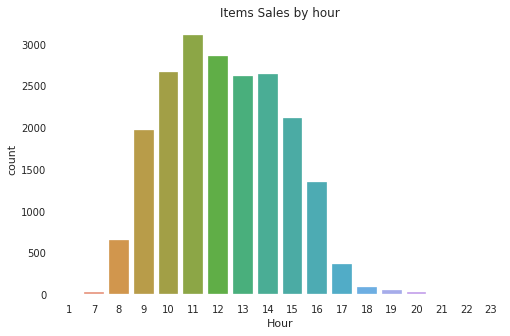

In [0]:
# Aggregate item sold by hour
bread_groupby_hour = bread.groupby("Hour").agg({"Item": lambda item: item.count()/total_days})
print(bread_groupby_hour)
print('\n')

# Plot items sold by hour
plt.figure(figsize=(8,5))
sns.countplot(x='Hour',data=bread)
plt.title('Items Sales by hour')
plt.show()

The period of lunch time is when there are more customers in the bakery, giving an opportunity to develop strategy of experimentation and promotions to customers experience new products

In [0]:
# sales groupby weekday
bread_groupby_weekday = bread.groupby("Weekday").agg({"Item": lambda item: item.count()})
bread_groupby_weekday.head()

,Item
Weekday,
1,2324
2,2392
3,2321
4,2646
5,3124


In [0]:
# but we need to find out how many each weekday in that period of transaction
# in order to calculate the average items per weekday

import datetime 
daterange = pd.date_range(datetime.date(2016, 10, 30), datetime.date(2017, 4, 9))

monday = 0
tuesday = 0
wednesday = 0
thursday = 0
friday = 0
saturday = 0
sunday = 0

for day in np.unique(bread.index.date):
    if day.isoweekday() == 1:
        monday += 1
    elif day.isoweekday() == 2:
        tuesday += 1
    elif day.isoweekday() == 3:
        wednesday += 1
    elif day.isoweekday() == 4:
        thursday += 1        
    elif day.isoweekday() == 5:
        friday += 1        
    elif day.isoweekday() == 6:
        saturday += 1        
    elif day.isoweekday() == 7:
        sunday += 1        
        
all_weekdays = monday + tuesday + wednesday + thursday + friday + saturday + sunday

print("monday = {0}, tuesday = {1}, wednesday = {2}, thursday = {3}, friday = {4}, saturday = {5}, sunday = {6}, total = {7}".format(monday, tuesday, wednesday, thursday, friday, saturday, sunday, all_weekdays))

monday = 21, tuesday = 23, wednesday = 23, thursday = 23, friday = 23, saturday = 23, sunday = 23, total = 159


In [0]:
# apply the conditions to calculate the average items for each weekday
conditions = [
    (bread_groupby_weekday.index == 1),
    (bread_groupby_weekday.index == 2),
    (bread_groupby_weekday.index == 3),
    (bread_groupby_weekday.index == 4),
    (bread_groupby_weekday.index == 5),
    (bread_groupby_weekday.index == 6),
    (bread_groupby_weekday.index == 7)]

choices = [bread_groupby_weekday.Item/21, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23, bread_groupby_weekday.Item/23]

bread_groupby_weekday["Average"] = np.select(conditions, choices, default=0)
bread_groupby_weekday

,Item,Average
Weekday,,
1,2324,110.666667
2,2392,104.000000
3,2321,100.913043
4,2646,115.043478
5,3124,135.826087
6,4605,200.217391
7,3095,134.565217


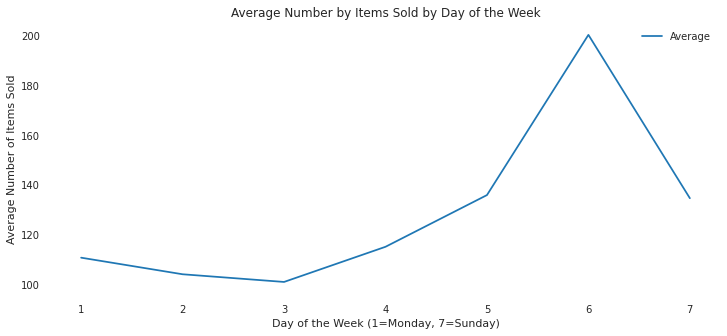

In [0]:
bread_groupby_weekday.plot(y="Average", figsize=(12,5), title="Average Number by Items Sold by Day of the Week").set(xlabel="Day of the Week (1=Monday, 7=Sunday)", ylabel="Average Number of Items Sold")
plt.show()

As weekend shows to be the best days of sales, the bakery can produce more in those days and reduce in the others days.
Another strategy is giving to the customer the perception that there are promotions in other days to increase the visit of the customer to the bakery to check what kind of promotion exists making the average sales during the weekdays increase

## **Machine Learning Algorithm**
---

### Preparing the dataset to Machine Learning

In [0]:
# Define dataset to machine learning
df_basket = bread.groupby(["Transaction","Item"]).size().reset_index(name="Count")

market_basket = (df.groupby(['Transaction', 'Item'])['Count'].sum().unstack().reset_index().fillna(0).set_index('Transaction'))
market_basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,...,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Convert all of our numbers to either a 1 or a 0 (negative numbers are converted to zero, positive numbers are converted to 1)
def encode_data(datapoint):
  if datapoint <= 0:
    return 0
  else:
    return 1

In [0]:
# Process the transformation into the market_basket dataset
market_basket = market_basket.applymap(encode_data)

# Check the result
market_basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,...,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Building the Apriori model

*   Support:
  * refers to the default popularity of an item and can be calculated by finding number of transactions containing a particular item divided by total number of transactions


*   Confidence:
  * refers to the likelihood that an item B is also bought if item A is bought. It can be calculated by finding the number of transactions where A and B are bought together, divided by total number of transactions where A is bought

*   Lift:
  * refers to the increase in the ratio of sale of B when A is sold. Lift(A –> B) can be calculated by dividing Confidence(A -> B) divided by Support(B)

*   Leverage:
  * computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent

*   Conviction:
   * A high conviction value means that the consequent is highly depending on the antecedent


In [0]:
# Apriori method request a min_support: Support is defined as the percentage of time that an itemset appears in the dataset.
# Defined to start seeing data/results with min_support of 2%
itemsets = apriori(market_basket, min_support= 0.02, use_colnames=True)

In [0]:
# Build your association rules using the mxltend association_rules function.
# min_threshold can be thought of as the level of confidence percentage that you want to return
# Defined to use 50% of min_threshold
rules = association_rules(itemsets, metric='lift', min_threshold=0.5)

In [0]:
# Below the list of products sales combinations
# It can use this information to build a cross-sell recommendation system that promotes these products with each other 
rules.sort_values("lift", ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(Tea),(Cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372
11,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865
27,(Coffee),(Toast),0.478394,0.033597,0.023666,0.049470,1.472431,0.007593,1.016699
26,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
19,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
18,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
21,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
20,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
16,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919
17,(Coffee),(Juice),0.478394,0.038563,0.020602,0.043065,1.116750,0.002154,1.004705


In [0]:
rules.support.to_numpy()

array([0.02377179, 0.02377179, 0.02366614, 0.02366614, 0.03518225,
       0.03518225, 0.04754358, 0.04754358, 0.02060222, 0.02060222,
       0.03824617, 0.03824617, 0.05472795, 0.05472795, 0.02820919,
       0.02820919, 0.02958267, 0.02958267, 0.02916006, 0.02916006,
       0.04986793, 0.04986793, 0.02334918, 0.02334918, 0.02810354,
       0.02810354, 0.09001585, 0.09001585])

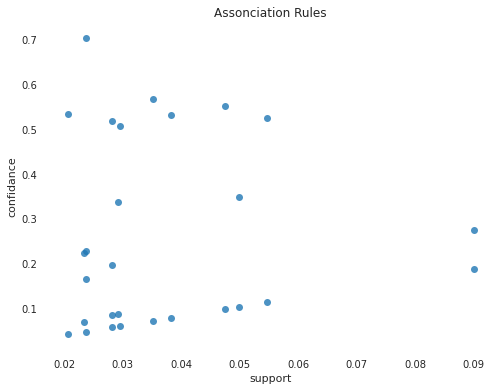

In [0]:
support = rules.support.to_numpy()
confidence = rules.confidence.to_numpy()

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.figure(figsize=(8,6))    
plt.title('Assonciation Rules')
plt.xlabel('support')
plt.ylabel('confidance')
sns.regplot(x=support, y=confidence, fit_reg=False)
plt.show()

### Recommendations filter


In [0]:
# Recommendation of Market Basket
rec_rules = rules[ (rules['lift'] > 1) & (rules['confidence'] >= 0.5) ]

In [0]:
# Recommendation of Market Basket Dataset
cols_keep = {'antecedents':'item_1', 'consequents':'item_2', 'support':'support', 'confidence':'confidence', 'lift':'lift'}
cols_drop = ['antecedent support', 'consequent support', 'leverage', 'conviction']

recommendation_basket = pd.DataFrame(rec_rules).rename(columns= cols_keep).drop(columns=cols_drop).sort_values(by=['lift'], ascending = False)
recommendation_basket['item_1'] = recommendation_basket['item_1'].str.join('()')
recommendation_basket['item_2'] = recommendation_basket['item_2'].str.join('()')
display(recommendation_basket)

,item_1,item_2,support,confidence,lift
26,Toast,Coffee,0.023666,0.704403,1.472431
18,Medialuna,Coffee,0.035182,0.569231,1.189878
20,Pastry,Coffee,0.047544,0.552147,1.154168
16,Juice,Coffee,0.020602,0.534247,1.116750
22,Sandwich,Coffee,0.038246,0.532353,1.112792
8,Cake,Coffee,0.054728,0.526958,1.101515
12,Cookies,Coffee,0.028209,0.518447,1.083723
14,Hot chocolate,Coffee,0.029583,0.507246,1.060311



* Interpretation and Implications
  * The recommendation_basket selected 8 itemsets sorted by lift > 1, confidence >= 0.5 and support > 1%
  * The support indicates how many transaction of the itemset (item_1 and item_2) occurs together.
  * The confidence >= 0.5 indicates that the itemset has the likelihood of the item_2 is bought when someone buys the item_1
  * The lift shows how item_1 helps to increase the sales of the item_2 when buying those items together
  * Ex: 
    * Toast and Coffee occurs nearly 2.4% of all transactions (support)
    * The confidence is about 70% showing that the probability to happen this transaction is high
    * Buying a toast shows that it increase in 47% the probability to buy Coffee showing the influence of Toast over Coffee.
    
  * So with the recommendation_basket the team (leader and employees) can be aligned to develop strategies and training to incentive customers who buys item_1 to include the item_2, doing a cross-selling and increasing the store's revenue.